In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
"/content/drive/MyDrive/deep/images_001.zip"

'/content/drive/MyDrive/deep/images_001.zip'

In [3]:
"/content/drive/MyDrive/deep/images_002.zip"

'/content/drive/MyDrive/deep/images_002.zip'

In [4]:
"/content/drive/MyDrive/deep/images_003.zip"

'/content/drive/MyDrive/deep/images_003.zip'

In [5]:
import zipfile

# zipファイルのパス
zip_path = "/content/drive/MyDrive/deep/images_001.zip"


# 解凍先のディレクトリを "archive" に指定して解凍
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("archive")

print("解凍完了")  # 解凍が完了したことを表示


解凍完了


In [6]:
import zipfile

# zipファイルのパス
zip_path = "/content/drive/MyDrive/deep/images_002.zip"


# 解凍先のディレクトリを "archive" に指定して解凍
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("archive")

print("解凍完了")  # 解凍が完了したことを表示


解凍完了


In [7]:
import zipfile

# zipファイルのパス
zip_path = "/content/drive/MyDrive/deep/images_003.zip"


# 解凍先のディレクトリを "archive" に指定して解凍
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("archive")

print("解凍完了")  # 解凍が完了したことを表示


解凍完了


In [8]:
import os
print(os.listdir("archive")) # List the contents of the extracted directory

['images_003', '__MACOSX', 'images_002', 'images_001']


In [9]:
import pandas as pd

csv_path = "/content/drive/MyDrive/deep/Data_Entry_2017.csv"

df = pd.read_csv(csv_path)

df.head

<bound method NDFrame.head of              Image Index          Finding Labels  Follow-up #  Patient ID  \
0       00000001_000.png            Cardiomegaly            0           1   
1       00000001_001.png  Cardiomegaly|Emphysema            1           1   
2       00000001_002.png   Cardiomegaly|Effusion            2           1   
3       00000002_000.png              No Finding            0           2   
4       00000003_000.png                  Hernia            0           3   
...                  ...                     ...          ...         ...   
112115  00030801_001.png          Mass|Pneumonia            1       30801   
112116  00030802_000.png              No Finding            0       30802   
112117  00030803_000.png              No Finding            0       30803   
112118  00030804_000.png              No Finding            0       30804   
112119  00030805_000.png              No Finding            0       30805   

        Patient Age Patient Gender View Position  OriginalImage[Width  \
0                58              M            PA                 2682   
1                58              M            PA                 2894   
2                58              M            PA                 2500   
3                81              M            PA                 2500   
4                81              F            PA                 2582   
...             ...            ...           ...                  ...   
112115           39              M            PA                 2048   
112116           29              M            PA                 2048   
112117           42              F            PA                 2048   
112118           30              F            PA                 2048   
112119           27              M            PA                 2048   

        Height]  OriginalImagePixelSpacing[x     y]  Unnamed: 11  
0          2749                        0.143  0.143          NaN  
1          2729                        0.143  0.143          NaN  
2          2048                        0.168  0.168          NaN  
3          2048                        0.171  0.171          NaN  
4          2991                        0.143  0.143          NaN  
...         ...                          ...    ...          ...  
112115     2500                        0.168  0.168          NaN  
112116     2500                        0.168  0.168          NaN  
112117     2500                        0.168  0.168          NaN  
112118     2500                        0.168  0.168          NaN  
112119     2500                        0.171  0.171          NaN  

[112120 rows x 12 columns]>

In [10]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/deep/Data_Entry_2017.csv")

# Massを含むかどうかで癌(1)　or 癌じゃない(0)のラベルを作る
df["Cancer"] = df["Finding Labels"].apply(lambda x: 1 if "Mass" in x else 0)
df_cancer = df[df["Cancer"] == 1]
print(len(df_cancer))  # 何件ある？




5782


In [11]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import Counter

# 1. 陰性データと陽性データをバランスさせる
df_1 = df[df["Cancer"] == 1]
df_0 = df[df["Cancer"] == 0].sample(n=5782, random_state=42)
df_balanced = pd.concat([df_0, df_1])


# 3. 実際に画像が存在する行だけ抽出 & Add full image path
valid_rows = []
image_dir = "archive" # Set the base directory for flow_from_dataframe

for idx, row in df_balanced.iterrows():
    filename = row["Image Index"]

    # Use forward slashes for path construction
    image_path1 = "images_001/images/" + filename
    image_path2 = "images_002/images/" + filename
    image_path3 = "images_003/images/" + filename

    full_image_path = None
    if os.path.exists(os.path.join(image_dir, image_path1)):
        full_image_path = image_path1
    elif os.path.exists(os.path.join(image_dir, image_path2)):
        full_image_path = image_path2
    elif os.path.exists(os.path.join(image_dir, image_path3)):
        full_image_path = image_path3


    if full_image_path:
        row['image_path'] = full_image_path # Add the full path relative to 'archive' to the row
        valid_rows.append(row)


# 4. New DataFrame
df_valid = pd.DataFrame(valid_rows)
print("Number of valid images:", len(df_valid))


df_cancer = df_valid[df_valid["Cancer"] == 1]
print(len(df_cancer))

Number of valid images: 2219
846


In [12]:
import os
from tqdm import tqdm
import cv2
import numpy as np

# image_dirを修正して、解凍先のディレクトリ内の画像ディレクトリを指すようにします

image_dir1 = "archive/images_001/images"
image_dir2 = "archive/images_002/images"
image_dir3 = "archive/images_003/images"

images = []
labels = []

for idx, row in tqdm(df_balanced.iterrows(), total=len(df_balanced)):
  filename = row["Image Index"]
  label = row["Cancer"]
  image_path1 = os.path.join(image_dir1, filename)
  image_path2 = os.path.join(image_dir2, filename)
  image_path3 = os.path.join(image_dir3, filename)





  if os.path.exists(image_path1):
    img = cv2.imread(image_path1,cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = cv2.resize(img, (224, 224))
    images.append(img)
    labels.append(label)

  if os.path.exists(image_path2):
    img = cv2.imread(image_path2,cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = cv2.resize(img, (224, 224))
    images.append(img)
    labels.append(label)

  if os.path.exists(image_path3):
    img = cv2.imread(image_path3,cv2.IMREAD_GRAYSCALE)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    img = cv2.resize(img, (224, 224))
    images.append(img)
    labels.append(label)



X = np.array(images)
y = np.array(labels)


print("画像データの形:", len(X))
print("ラベルの形:", len(y))

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)








100%|██████████| 11564/11564 [00:46<00:00, 246.28it/s] 


画像データの形: 2219
ラベルの形: 2219


In [13]:
print("Xの中身の数:",len(X))
print("ラベルの数:", len(y))

Xの中身の数: 2219
ラベルの数: 2219


In [14]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rename the 'Cancer' column to 'class' for flow_from_dataframe
df_valid = df_valid.rename(columns={"Cancer": "class"})

# Convert the 'class' column to string type
df_valid['class'] = df_valid['class'].astype(str)


# データ分割
train_df, test_df = train_test_split(df_valid, test_size=0.2, stratify=df_valid["class"], random_state=42)

# データ拡張ジェネレータ
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)


# 画像サイズを128x128に縮小
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="archive",
    x_col='image_path',
    y_col='class',
    target_size=(128, 128),
    color_mode='rgb',
    batch_size=32,
    class_mode='binary'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory="archive",
    x_col='image_path',
    y_col='class',
    target_size=(128, 128),
    color_mode='rgb',
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 1775 validated image filenames belonging to 2 classes.
Found 444 validated image filenames belonging to 2 classes.


In [15]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf # Import tensorflow

# 転移学習ベース
base_model = DenseNet121(include_top=False, input_shape=(128, 128, 3), pooling='avg', weights='imagenet')
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

# モデル定義
model = models.Sequential([
    base_model,
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Recall(name='recall')]) # Use tf.keras.metrics

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
from sklearn.utils import class_weight
import numpy as np

# クラス重みの計算
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df_valid['class']),
    y=df_valid['class']
)
class_weights_dict = dict(enumerate(class_weights))

# コールバック
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

In [17]:


# 学習実行
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    class_weight=class_weights_dict,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5125 - auc: 0.4974 - loss: 0.7886 - recall: 0.4557

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


56/56 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.5128 - auc: 0.4979 - loss: 0.7880 - recall: 0.4566 - val_accuracy: 0.5608 - val_auc: 0.5469 - val_loss: 0.7330 - val_recall: 0.4852 - learning_rate: 1.0000e-04
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 141s 3s/step - accuracy: 0.5632 - auc: 0.6007 - loss: 0.6992 - recall: 0.6155 - val_accuracy: 0.6059 - val_auc: 0.5908 - val_loss: 0.7019 - val_recall: 0.4793 - learning_rate: 1.0000e-04
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.6018 - auc: 0.6460 - loss: 0.6595 - recall: 0.6104 - val_accuracy: 0.6239 - val_auc: 0.5997 - val_loss: 0.7127 - val_recall: 0.5621 - learning_rate: 1.0000e-04
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 143s 3s/step - accuracy: 0.6042 - auc: 0.6551 - loss: 0.6671 - recall: 0.6461 - val_accuracy: 0.6306 - val_auc: 0.6281 - val_loss: 0.6678 - val_recall: 0.4320 - learning_rate: 1.0000e-04
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 215s 3s/step - accuracy: 0.6549 - auc: 0.7077 - loss: 0.6268 - recall: 0.

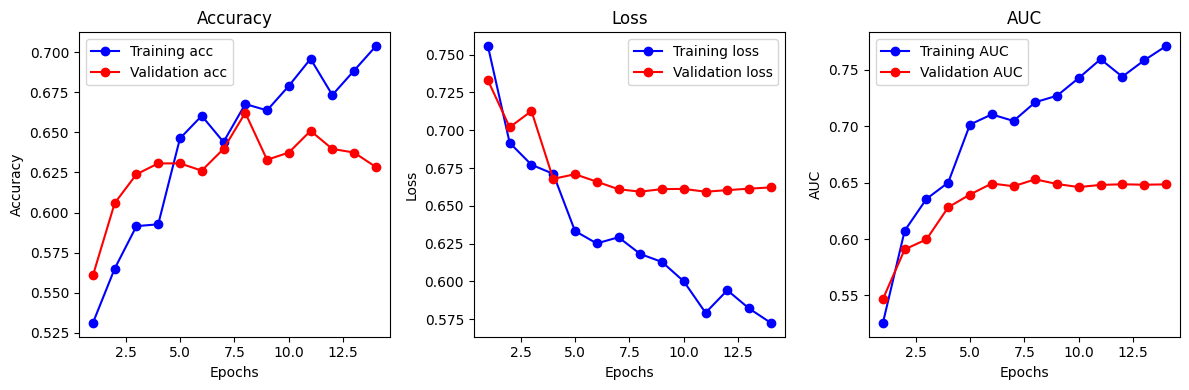

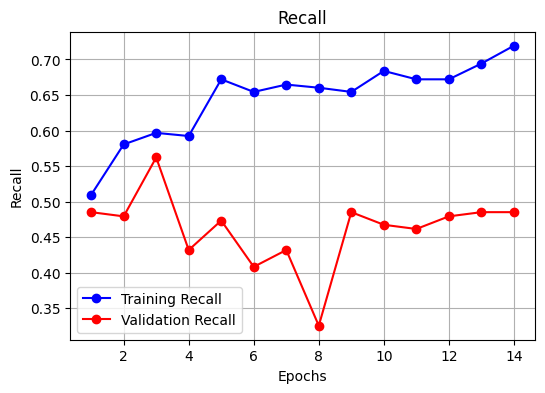

In [18]:
import matplotlib.pyplot as plt

# history から値を取得
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
auc = history.history.get('auc', [])
val_auc = history.history.get('val_auc', [])
recall = history.history.get('recall', [])
val_recall = history.history.get('val_recall', [])

epochs = range(1, len(acc) + 1)

# 精度の可視化
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(epochs, acc, 'bo-', label='Training acc')
plt.plot(epochs, val_acc, 'ro-', label='Validation acc')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# 損失の可視化
plt.subplot(1, 3, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# AUCの可視化（あれば）
if auc:
    plt.subplot(1, 3, 3)
    plt.plot(epochs, auc, 'bo-', label='Training AUC')
    plt.plot(epochs, val_auc, 'ro-', label='Validation AUC')
    plt.title('AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

plt.tight_layout()
plt.show()

# Recallも表示（オプション）
if recall:
    plt.figure(figsize=(6, 4))
    plt.plot(epochs, recall, 'bo-', label='Training Recall')
    plt.plot(epochs, val_recall, 'ro-', label='Validation Recall')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.grid()
    plt.show()

In [20]:
# モデルを保存する
from google.colab import drive
drive.mount('/content/drive')

# It's recommended to save in the native Keras format (.keras)
model.save("/content/drive/MyDrive/cancer_detector_model.keras")

# If you specifically need the HDF5 format (legacy), use the line below instead:
# model.save("/content/drive/MyDrive/cancer_detector_model.h5")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("cancer_detector_model.h5")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'cancer_detector_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
# Assuming the model has been loaded into the 'model' variable
# and the image has been loaded and preprocessed into the 'img' variable.
# The 'img' variable should have the shape (1, 224, 224, 3) based on previous cells.

# 画像予測
prediction = model.predict(img)

# You can now print the prediction score
print("予測スコア：", prediction[0])


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 224), dtype=float32). Expected shape (None, 224, 224, 3), but input has incompatible shape (32, 224)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 224), dtype=float32)
  • training=False
  • mask=None

In [ ]:
import cv2
import numpy as np
from google.colab import files # ファイルを読み込む

# ファイルをアップロード
upload = files.upload()

# ファイルがアップロードされたか確認
if not upload:
    print("No file uploaded.")
else:
    file_name = list(upload.keys())[0]

    print(f"Uploaded file: {file_name}")

    # 画像を読み込む
    img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)


    if img is None:
        print(f"Error loading image: {file_name}. Please check if the file name is correct and the file is not corrupted.")
    else:
        # 画像サイズ変更
        img = cv2.resize(img, (224, 224))

        # 0~1の範囲にする
        img = img / 255.0

        # 形を整える
        img = img.reshape(1, 224, 224, 3)

        print("Image loaded and processed successfully.")
        # You can now use 'img' for prediction or further processing

Saving 癌.jpg to 癌 (3).jpg
Uploaded file: 癌 (3).jpg


ValueError: cannot reshape array of size 50176 into shape (1,224,224,3)

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.models import load_model
model = load_model("cancer_detector_model.h5")

# 画像予測
prediction = model.predict(img)

# 結果表示
if prediction[0] > 0.5:
  print("AIの予測: 癌の可能性があります(陽性)")
  result = "AIの予測: 癌の可能性があります(陽性)"
else:
  print("AIの予測: 癌は見られません(陰性)")
  result = "AIの予測: 癌は見られません(陰性)"



# 画像と結果表示
plt.figure(figsize=(4,4))
plt.imshow(img.reshape(128, 128), cmap="gray")
plt.title(result)
plt.axis("off")
plt.show()

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("sequential_2_1/Cast:0", shape=(32, 128), dtype=float32). Expected shape (None, 128, 128, 1), but input has incompatible shape (32, 128)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32, 128), dtype=uint8)
  • training=False
  • mask=None

In [ ]:
# モデルを保存する
model.save("cancer_detector_model.h5")


In [ ]:
from tensorflow.keras.models import load_model
model = load_model("cancer_detector_model.h5")


In [ ]:
import cv2
import numpy as np
from google.colab import files # ファイルを読み込む

# ファイルをアップロード
upload = files.upload()

# ファイルがアップロードされたか確認
if not upload:
    print("No file uploaded.")
else:
    file_name = list(upload.keys())[0]

    print(f"Uploaded file: {file_name}")

    # 画像を読み込む
    img = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)


    if img is None:
        print(f"Error loading image: {file_name}. Please check if the file name is correct and the file is not corrupted.")
    else:
        # 画像サイズ変更
        img = cv2.resize(img, (128, 128))

        # 0~1の範囲にする
        img = img / 255.0

        # 形を整える
        img = img.reshape(1, 128, 128, 1)

        print("Image loaded and processed successfully.")
        # You can now use 'img' for prediction or further processing

Saving 癌.jpg to 癌 (1).jpg
Uploaded file: 癌 (1).jpg
Image loaded and processed successfully.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
AIの予測: 癌は見られません(陰性)


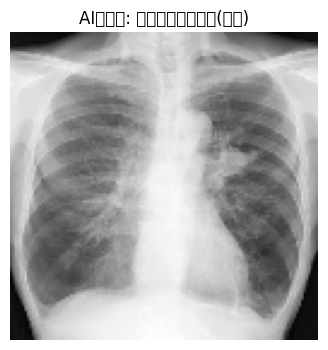

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.models import load_model
model = load_model("cancer_detector_model.h5")

# 画像予測
prediction = model.predict(img)

# 結果表示
if prediction[0] > 0.5:
  print("AIの予測: 癌の可能性があります(陽性)")
  result = "AIの予測：癌の可能性があります(陽性)"
else:
  print("AIの予測: 癌は見られません(陰性)")
  result = "AIの予測: 癌は見られません(陰性)"



# 画像と結果表示
plt.figure(figsize=(4,4))
plt.imshow(img.reshape(128, 128), cmap="gray")
plt.title(result)
plt.axis("off")
plt.show()

In [ ]:
# モデルを保存する
model.save("cancer_detector_model.h5")
